Aqui, começaremos a atacar o problema de sincronizar nossos arquivos de audio com os acordes escritos. Primeiramente, tentaremos, para uma dada música, determinar os acordes por compasso. Faremos isso tomando como base os arquivos em formato xml.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
song_title = 'Gillette'
tree = ET.parse('corpus/xml/{}.xml'.format(song_title))
root = tree.getroot()

In [2]:
part = root.findall('part')[0]
measures = part.findall('measure')
for measure in measures:
    chords = measure.findall('harmony')
    for chord in chords:
        try:
            note = chord.find('root/root-step').text

        except AttributeError: # se não achar a nota "root" do acorde, não tem acorde
            print('Measure: {}'.format(measure.attrib['number']), ' | ', 'No chords')
            continue
            
        if note:
            # alter é a alteração de um acorde (nem sempre existe): b ou #.
            alter = chord.find('root/root-alter')#.text
            
            # kind é o tipo do acorde (nem sempre existe): pode ser com 7a, 9a, 13a, por aí vai...
            kind = chord.find('kind')#.attrib['text']
            
            # bass é o baixo do acorde, quando diferente da tônica. Também nem sempre existe.
            bass = chord.find('bass/bass-step')#.text
            
            # bass_alter é e alteração do baixo, podendo ser b ou #. Também nem sempre existe.
            bass_alter = chord.find('bass/bass-alter')#.text
            
            attribs_dict = {'alter':alter, 
                            'kind':kind, 
                            'bass':bass, 
                            'bass_alter':bass_alter}

            for key, value in attribs_dict.items():
                if value is None:
                    attribs_dict[key] = ''
                elif key == 'kind':
                    attribs_dict[key] = value.attrib['text']
                else:
                    attribs_dict[key] = value.text
                    
            print('Measure: {}'.format(measure.attrib['number']), '|', 'Chord: ', note, 
                  attribs_dict['alter'], attribs_dict['kind'],'/',attribs_dict['bass'],attribs_dict['bass_alter'])
            

Measure: 1 | Chord:  B -1  /  
Measure: 5 | Chord:  F  7 /  
Measure: 9 | Chord:  B -1  /  
Measure: 11 | Chord:  E -1  /  
Measure: 13 | Chord:  F   /  
Measure: 13 | Chord:  E  dim /  
Measure: 13 | Chord:  C  min6 /  
Measure: 13 | Chord:  D  min7 /  
Measure: 14 | Chord:  A  min /  
Measure: 14 | Chord:  F  7 /  
Measure: 15 | Chord:  B -1 7 /  
Measure: 17 | Chord:  B -1 7 /  


Comparando com a partitura aberta no musescore parece fazer sentido, só preciso conseguir fazer com que mostre também os compassos em que não tem acorde (no caso da música que estamos usando como exemplo, os compassos 1 e 2).

Agora, vamos modificar ligeiramente o código acima para adicionar as informações em um dataframe.

In [3]:
df_teste = pd.DataFrame(columns=[song_title])
df_add = pd.DataFrame(columns=[song_title], 
                      index=[3], 
                      data='E -1 min7')

df_add_2 = pd.DataFrame(columns=[song_title], 
                      index=[3], 
                      data='D -1')

In [4]:
df_teste = df_teste.append(df_add)

In [5]:
df_teste.append(df_add_2)

,Gillette
3,E -1 min7
3,D -1


In [6]:
df_harmony = pd.DataFrame(columns=[song_title])

part = root.findall('part')[0]
measures = part.findall('measure')

for measure in measures:
    chords = measure.findall('harmony')
    for chord in chords:
        try:
            note = chord.find('root/root-step').text

        except AttributeError: # se não achar a nota "root" do acorde, não tem acorde
            print('Measure: {}'.format(measure.attrib['number']), ' | ', 'No chords')
            continue
            
        if note:
            # alter é a alteração de um acorde (nem sempre existe): b ou #.
            alter = chord.find('root/root-alter')#.text
            
            # kind é o tipo do acorde (nem sempre existe): pode ser com 7a, 9a, 13a, por aí vai...
            kind = chord.find('kind')#.attrib['text']
            
            # bass é o baixo do acorde, quando diferente da tônica. Também nem sempre existe.
            bass = chord.find('bass/bass-step')#.text
            
            # bass_alter é e alteração do baixo, podendo ser b ou #. Também nem sempre existe.
            bass_alter = chord.find('bass/bass-alter')#.text
            
            attribs_dict = {'alter':alter, 
                            'kind':kind, 
                            'bass':bass, 
                            'bass_alter':bass_alter}

            for key, value in attribs_dict.items():
                if value is None:
                    attribs_dict[key] = ''
                elif key == 'kind':
                    attribs_dict[key] = value.attrib['text']
                else:
                    attribs_dict[key] = value.text
                    
                    
            measure_number = measure.attrib['number']
            chord = note + attribs_dict['alter'] + attribs_dict['kind']
            chord_bass = attribs_dict['bass']+attribs_dict['bass_alter']
            complete_chord = chord + '/' + chord_bass
            
            if complete_chord.endswith('/'):
                complete_chord = complete_chord[:-1]
            
            df_chord = pd.DataFrame(columns=[song_title], index=[measure_number], data=complete_chord)
            df_harmony = df_harmony.append(df_chord)
            
df_harmony.index.names = ['Measure']

In [7]:
df_harmony.index.unique()

Index(['1', '5', '9', '11', '13', '14', '15', '17'], dtype='object', name='Measure')

In [8]:
df_harmony.index.value_counts()

13    4
14    2
5     1
11    1
17    1
9     1
15    1
1     1
Name: Measure, dtype: int64

In [9]:
df_harmony

,Gillette
Measure,
1,B-1
5,F7
9,B-1
11,E-1
13,F
13,Edim
13,Cmin6
13,Dmin7
14,Amin


Agora vamos procurar os momentos de mudança de acorde. Vasculhando os arquivos xml que temos em nosso corpus, pudemos ver que as informações sobre andamento (em bpm) e tipo de compasso encontram-se na seção do primeiro compasso. Segue:

#### Tipo de compasso

In [10]:
first_measure = measures[0]
cima = first_measure.find('attributes').find('time/beats').text
baixo = first_measure.find('attributes').find('time/beat-type').text

compasso = cima + '/' + baixo
compasso

'2/2'

#### Andamento
16/06: Depois de séculos trabalhando nisso, descobri que a ferramenta do music21 que eu usei pra gerar os audios a partir dos xml ignora a informação de andamento presente no arquivo. Simplesmente. kkkk

Ela coloca tudo com andamento 120 bpm. Então simbora kk

In [19]:
andamento = 120 #first_measure.find('sound').attrib['tempo']# + ' bpm'
andamento
# em bpm

120

#### Sync: Acorde + minutagem

In [27]:
duracao_seminima = 60/int(andamento) # em segundos

In [28]:
segs_compasso = (4/int(baixo)) * int(cima) * duracao_seminima

In [29]:
df_harmony.index = df_harmony.index.astype(int)

In [30]:
for compasso in df_harmony.index.unique():
    acordes = df_harmony.loc[[compasso]]
    n_acordes = len(acordes)
#     print(compasso, n_acordes)
    inicio_compasso = (int(compasso) - 1) * segs_compasso
    
    if n_acordes == 1:
        tempos = inicio_compasso
    
    else:        
        tempos = np.linspace(inicio_compasso,
                             inicio_compasso + segs_compasso,
                             n_acordes+1)
        tempos = tempos[:-1]
    
    df_harmony.at[compasso, 'Time'] = tempos

In [31]:
df_harmony

,Gillette,Time
Measure,,
1,B-1,0.0
5,F7,8.0
9,B-1,16.0
11,E-1,20.0
13,F,24.0
13,Edim,24.5
13,Cmin6,25.0
13,Dmin7,25.5
14,Amin,26.0


Text(0.5, 0, 'time')

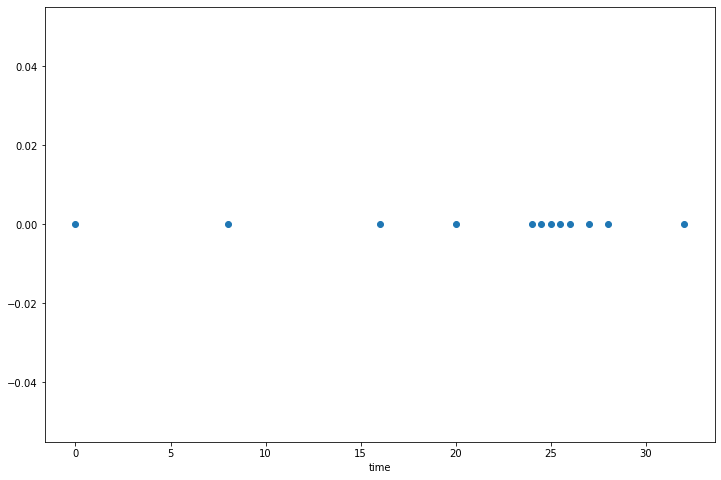

In [41]:
plt.figure(figsize=(12,8))
plt.plot(df_harmony['Time'], np.zeros(12), 'o')
plt.xlabel('time')